# Bibliotecas

In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import librosa.display
import os
import numpy as np
import pickle
from IPython.display import Audio, display


2025-11-29 17:00:23.707801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 17:00:24.076802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-29 17:00:25.368248: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Confirmação de GPU

In [2]:
print('TF version:', tf.__version__)
print('GPUs:', tf.config.list_physical_devices('GPU'))

TF version: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Pré Processamento dos Dados

## Caminhos 

In [3]:

# Caminho base é a pasta onde o notebook está
BASE_DIR = os.getcwd()

# 1. Caminho para as pastas fold1...fold10
CAMINHO_RAIZ_AUDIO = os.path.join(BASE_DIR, "UrbanSound8K","audio")

# 2. Caminho para o ficheiro CSV
CAMINHO_CSV = os.path.join(BASE_DIR, "UrbanSound8K", "metadata", "UrbanSound8K.csv")

# 3. Carregar o ficheiro CSV
metadata = pd.read_csv(CAMINHO_CSV)

metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Pré visualização dos Dados

### Distribuição por Classes 

                  count  percent
class                           
dog_bark           1000    11.45
children_playing   1000    11.45
air_conditioner    1000    11.45
street_music       1000    11.45
engine_idling      1000    11.45
jackhammer         1000    11.45
drilling           1000    11.45
siren               929    10.64
car_horn            429     4.91
gun_shot            374     4.28


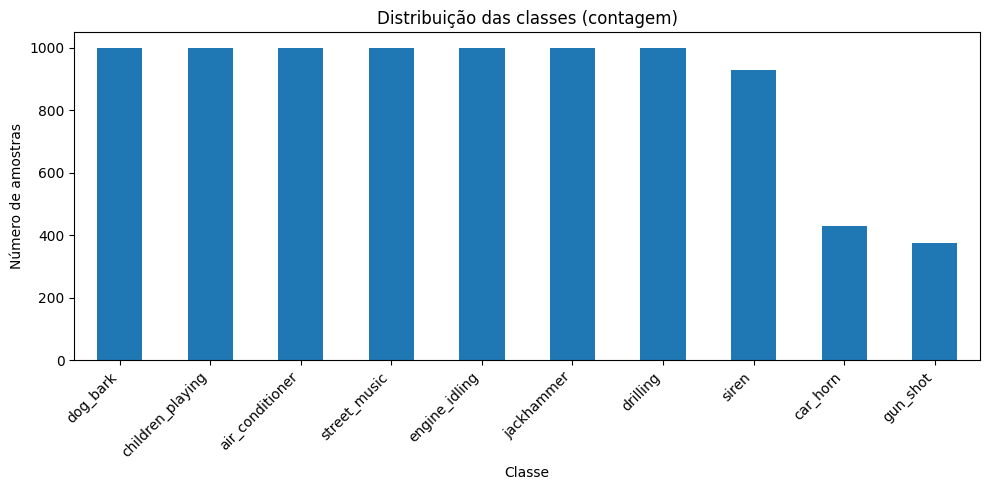

In [5]:
# Distribuição das classes usando o DataFrame `metadata`
counts = metadata['class'].value_counts().sort_values(ascending=False)
percent = counts / counts.sum() * 100

# Mostrar tabela resumida
dist_df = pd.DataFrame({'count': counts, 'percent': percent.round(2)})
print(dist_df)

# Gráfico de barras
plt.figure(figsize=(10,5))
counts.plot(kind='bar', color='C0')
plt.title('Distribuição das classes (contagem)')
plt.xlabel('Classe')
plt.ylabel('Número de amostras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Ficheiros de Áudio 

In [6]:
# Pequeno utilitário para listar e reproduzir um ficheiro da pasta "audio"
TARGET_SR = 22050  # Taxa de amostragem alvo 
def listar_audios(base_path=CAMINHO_RAIZ_AUDIO, max_items=30):
    # lista as subpastas (folds) e alguns ficheiros em cada uma
    folds = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    print("Folds encontrados:", folds)
    for fold in folds:
        files = sorted(os.listdir(os.path.join(base_path, fold)))[:max_items]
        print(f"\n{fold} (mostrando até {max_items}):")
        for i,f in enumerate(files):
            print(f"  [{i}] {f}")
    return folds

def reproduzir_audio(fold, filename, sr=TARGET_SR):
    caminho = os.path.join(CAMINHO_RAIZ_AUDIO, fold, filename)
    if not os.path.exists(caminho):
        raise FileNotFoundError(f"Ficheiro não encontrado: {caminho}")
    y, sr_loaded = librosa.load(caminho, sr=sr, mono=True)
    dur = len(y) / sr_loaded
    print(f"Reproduzindo: {caminho}  —  sr={sr_loaded}, duração={dur:.2f}s")
    display(Audio(y, rate=sr_loaded))

# Exemplo de uso:
listar_audios()  #  ver folds e ficheiros disponíveis
reproduzir_audio('fold5', '100032-3-0-0.wav')

Folds encontrados: ['fold1', 'fold10', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9']

fold1 (mostrando até 30):
  [0] .DS_Store
  [1] 101415-3-0-2.wav
  [2] 101415-3-0-3.wav
  [3] 101415-3-0-8.wav
  [4] 102106-3-0-0.wav
  [5] 102305-6-0-0.wav
  [6] 102842-3-0-1.wav
  [7] 102842-3-1-0.wav
  [8] 102842-3-1-5.wav
  [9] 102842-3-1-6.wav
  [10] 103074-7-0-0.wav
  [11] 103074-7-0-1.wav
  [12] 103074-7-0-2.wav
  [13] 103074-7-1-0.wav
  [14] 103074-7-1-1.wav
  [15] 103074-7-1-2.wav
  [16] 103074-7-1-3.wav
  [17] 103074-7-1-4.wav
  [18] 103074-7-1-5.wav
  [19] 103074-7-1-6.wav
  [20] 103074-7-2-0.wav
  [21] 103074-7-3-0.wav
  [22] 103074-7-3-1.wav
  [23] 103074-7-3-2.wav
  [24] 103074-7-3-3.wav
  [25] 103074-7-4-0.wav
  [26] 103074-7-4-1.wav
  [27] 103074-7-4-2.wav
  [28] 103074-7-4-3.wav
  [29] 103074-7-4-4.wav

fold10 (mostrando até 30):
  [0] .DS_Store
  [1] 100648-1-0-0.wav
  [2] 100648-1-1-0.wav
  [3] 100648-1-2-0.wav
  [4] 100648-1-3-0.wav
  [5] 100648-1-4-0.wav


c:\Users\jproc_vj4ovlo\anaconda3\envs\AC2\lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


Reproduzindo: c:\Users\jproc_vj4ovlo\Desktop\TrabalhoAC\UrbanSound8K\UrbanSound8K\audio\fold5\100032-3-0-0.wav  —  sr=22050, duração=0.32s


## Transforamção em Mels 

In [14]:

NUM_CLASSES = 10
class_names = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]

In [15]:
TARGET_SR = 22050  # Taxa de amostragem alvo 
DURACAO_ALVO_SEGUNDOS = 4.0  # Duração do Audio
NUM_AMPLITUDES_ALVO = int(TARGET_SR * DURACAO_ALVO_SEGUNDOS) # 88200 Amplitudes por ficheiro de som 
N_MFCC = 40        # Número de coeficientes MFCC a extrair

### Sampling Rate

Esta função recebe o caminho de um ficheiro de áudio e uma taxa de amostragem alvo (sendo escolhido 22050 Hz) e utiliza a biblioteca librosa para carregar o ficheiro, convertendo-o automaticamente para a taxa de amostragem especificada e para formato mono (canal único). A função retorna o sinal de áudio processado como um array NumPy.

In [16]:
#Uniformizar a Taxa de Amostragem
def uniformizar_sampling_rate(caminho_ficheiro, taxa_alvo=TARGET_SR):
    try:
        # Carrega e reamostra numa única operação
        sinal_audio, sr = librosa.load(
            caminho_ficheiro, 
            sr=taxa_alvo, 
            mono=True
        )
        return sinal_audio
    except Exception as e:
        print(f"Erro ao processar o ficheiro {caminho_ficheiro}: {e}")
        return None

### Duração do Áudio 

Esta função garante que todos os sinais de áudio tenham exatamente o mesmo número de amostras (NUM_AMPLITUDES_ALVO). A função primeiro verifica se o sinal é válido e depois compara o comprimento atual do sinal com o comprimento alvo: 
- se o sinal for mais longo, é truncado mantendo apenas a parte inicial
- se for mais curto, são adicionados zeros no final para completar o tamanho necessário 
- se já tiver o tamanho correto, é retornado sem alterações
Esta normalização permite que ficheiros de áudio com durações diferentes sejam processados de forma uniforme, criando um dataset homogéneo onde todos os exemplos têm as mesmas dimensões.

In [18]:
#Normalização da Duração e Padding
def normalizar_duracao(sinal_audio, num_amostras_alvo = NUM_AMPLITUDES_ALVO):
    
    # Trunca ou aplica padding a um sinal de áudio para que tenha um número fixo de amostras.
    
    
    if sinal_audio is None:
        return None
        
    num_amostras_atuais = len(sinal_audio)
    
    if num_amostras_atuais > num_amostras_alvo:
        # Truncagem (mantendo o início)
        sinal_normalizado = sinal_audio[:num_amostras_alvo]
        
    elif num_amostras_atuais < num_amostras_alvo:
        # Padding (adicionar zeros no final)
        padding_necessario = num_amostras_alvo - num_amostras_atuais
        
        sinal_normalizado = np.pad(
            sinal_audio, 
            (0, padding_necessario), 
            mode='constant'
        )
        
    else:
        # Já tem o tamanho alvo
        sinal_normalizado = sinal_audio
        
    return sinal_normalizado

### Obtenção das MELS e das Derivadas

In [19]:
def extrair_mels(sinal_normalizado, sr=TARGET_SR, n_mels=128, n_fft=2048, hop_length=512, to_db=True):
    if sinal_normalizado is None:
        return None

    S = librosa.feature.melspectrogram(
        y=sinal_normalizado,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        power=2.0
    )

    if to_db:
        return librosa.power_to_db(S, ref=np.max)
    return S


In [20]:


def processar_dataset_mels_to_df(caminho_csv, caminho_raiz_audio,
                                 n_mels=128, n_fft=2048, hop_length=512, to_db=True):
    """
    Extrai Mels + Delta + Delta-delta e codifica labels para one-hot usando o mapping definido.
    Retorna um DataFrame com colunas: 'features' (3D array), 'classe' (int), 'fold', 'file_name'
    """

    metadata = pd.read_csv(caminho_csv)
    dados_lista = []

    print("A iniciar processamento...")

    for index, row in metadata.iterrows():
        fold = row["fold"]
        fname = row["slice_file_name"]
        classe_str = row["class"]
        path = os.path.join(caminho_raiz_audio, f"fold{fold}", fname)

        # Carregar e uniformizar
        y = uniformizar_sampling_rate(path)

        if y is not None:
            # Normalizar tamanho
            y = normalizar_duracao(y)

            # Extrair Mels
            mel = extrair_mels(y, TARGET_SR, n_mels, n_fft, hop_length, to_db)
            
            # Calcular Deltas
            mel_delta = librosa.feature.delta(mel)
            mel_delta2 = librosa.feature.delta(mel, order=2)

            # Empilhar canais (Mels, Delta, Delta2)
            mel_stack = np.stack([mel, mel_delta, mel_delta2], axis=-1)

            # Mapear classe string para índice
            classe_int = class_names.index(classe_str)

            # Adicionar à lista
            dados_lista.append({
                'features': mel_stack,
                'classe': classe_int,
                'fold': fold,
                'file_name': fname
            })

        if index % 300 == 0:
            print(f"{index}/{len(metadata)} processados...")

    print("A criar DataFrame...")
    df_final = pd.DataFrame(dados_lista)

    # One-hot
    df_final['label_one_hot'] = df_final['classe'].apply(lambda x: to_categorical(x, num_classes=NUM_CLASSES))

    print("Concluído.")
    return df_final


### Visualização dos Dados


A testar ficheiro: 100652-3-0-2.wav
   Duração Original: 4.00s (88200 amostras)
   Duração Normalizada: 4.00s (88200 amostras)


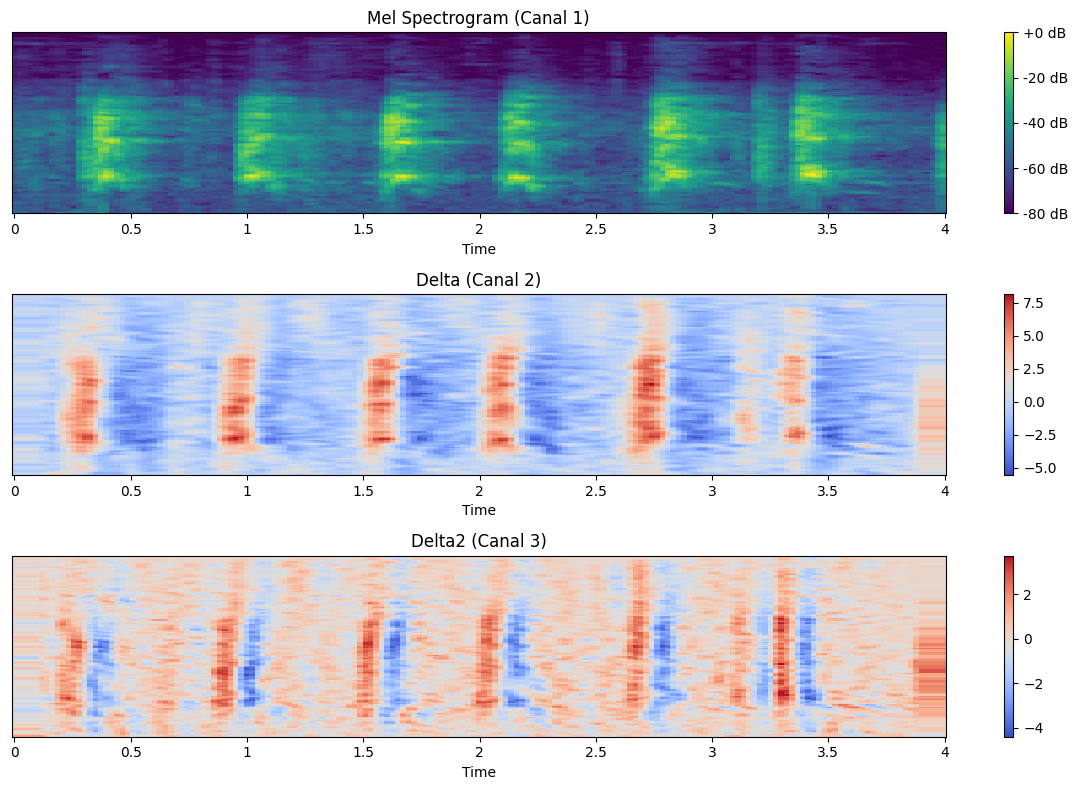


DADOS FINAIS:
   Shape do Tensor: (128, 173, 3)
   (Mels: 128, Frames: 173, Canais: 3)
O formato está CORRETO para a CNN.


In [13]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

def testar_um_ficheiro(caminho_arquivo, n_mels=128, n_fft=2048, hop_length=512):
    """
    Carrega UM ficheiro específico, processa-o totalmente
    e mostra os gráficos e o formato final dos dados.
    """
    
    print(f"A testar ficheiro: {os.path.basename(caminho_arquivo)}")
    
    # 1. Carregar e Uniformizar (Simulação do pipeline real)
    try:
        y, sr = librosa.load(caminho_arquivo, sr=TARGET_SR, mono=True)
    except FileNotFoundError:
        print("Ficheiro não encontrado!")
        return None

    # 2. Normalizar Duração
    print(f"   Duração Original: {len(y)/sr:.2f}s ({len(y)} amostras)")
    y = normalizar_duracao(y) # Usa a tua função já definida
    print(f"   Duração Normalizada: {len(y)/sr:.2f}s ({len(y)} amostras)")

    # 3. Extrair Mels e Deltas
    # Mel
    mel = extrair_mels(y, sr, n_mels, n_fft, hop_length, to_db=True)
    # Deltas
    mel_delta = librosa.feature.delta(mel)
    mel_delta2 = librosa.feature.delta(mel, order=2)
    
    # Stack (O formato final para a CNN)
    # Shape esperado: (128, 173, 3)
    mel_stack = np.stack([mel, mel_delta, mel_delta2], axis=-1)

    # --- VISUALIZAÇÃO ---
    plt.figure(figsize=(12, 8))
    
    # Mel
    plt.subplot(3, 1, 1)
    librosa.display.specshow(mel, x_axis='time', sr=sr, hop_length=hop_length, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram (Canal 1)')
    
    # Delta
    plt.subplot(3, 1, 2)
    librosa.display.specshow(mel_delta, x_axis='time', sr=sr, hop_length=hop_length, cmap='coolwarm')
    plt.colorbar()
    plt.title(f'Delta (Canal 2)')
    
    # Delta2
    plt.subplot(3, 1, 3)
    librosa.display.specshow(mel_delta2, x_axis='time', sr=sr, hop_length=hop_length, cmap='coolwarm')
    plt.colorbar()
    plt.title(f'Delta2 (Canal 3)')
    
    plt.tight_layout()
    plt.show()

    # --- RESULTADO FINAL (Simulação do DataFrame) ---
    print(f"\nDADOS FINAIS:")
    print(f"   Shape do Tensor: {mel_stack.shape}")
    print(f"   (Mels: {mel_stack.shape[0]}, Frames: {mel_stack.shape[1]}, Canais: {mel_stack.shape[2]})")
    
    if mel_stack.shape == (128, 173, 3):
        print("O formato está CORRETO para a CNN.")
    else:
        print("AVISO: O formato é diferente do esperado (128, 173, 3).")

    # Retorna o array para poderes inspecionar a variável se quiseres
    return mel_stack

# --- COMO USAR ---

# 1. Escolhe um ficheiro de exemplo (pode ser o primeiro do teu CSV)
metadata = pd.read_csv(CAMINHO_CSV)
primeira_linha = metadata.iloc[16]
caminho_exemplo = os.path.join(CAMINHO_RAIZ_AUDIO, f"fold{primeira_linha['fold']}", primeira_linha['slice_file_name'])

# 2. Corre a função
dados_teste = testar_um_ficheiro(caminho_exemplo)

### Guardar em Pickles 

In [21]:
import os
import pandas as pd

def garantir_pickle_mels(nome_pickle, caminho_csv, caminho_raiz_audio, 
                          pasta_cache="dados_processados", **kwargs):
    """
    Verifica se o pickle existe.
    Se sim -> Não faz nada (apenas avisa).
    Se não -> Processa os dados e salva em disco como .pkl simples (sem compressão).
    """

    # Garantir que a pasta de destino existe
    if not os.path.exists(pasta_cache):
        os.makedirs(pasta_cache)

    caminho_completo = os.path.join(pasta_cache, nome_pickle)

    # 1. VERIFICAR SE EXISTE
    if os.path.exists(caminho_completo):
        print(f"O ficheiro '{nome_pickle}' já existe em '{pasta_cache}'.")
        print("Nenhuma ação necessária.")
        return # Sai da função

    # 2. SE NÃO EXISTE, PROCESSAR
    else:
        print(f"Ficheiro '{nome_pickle}' não encontrado.")
        print("A iniciar processamento de áudio (Isto pode demorar)...")
        
        # Certifica-te que tens a função 'processar_dataset_mels_to_df' importada ou definida
        df = processar_dataset_mels_to_df(caminho_csv, caminho_raiz_audio, **kwargs)
        
        # 3. SALVAR (ALTERADO AQUI)
        print(f"A salvar em: {caminho_completo} ...")
        try:
            # compression=None garante que é salvo como pickle puro
            df.to_pickle(caminho_completo, compression=None, protocol=4) 
            print("Processamento concluído e ficheiro salvo com sucesso (sem compressão).")
        except Exception as e:
            print(f"Erro ao salvar o ficheiro: {e}")
        
        # Limpar memória
        del df

In [22]:
garantir_pickle_mels(
    nome_pickle="urbansound_mels_128.pkl",
    caminho_csv=CAMINHO_CSV,
    caminho_raiz_audio=CAMINHO_RAIZ_AUDIO,
    n_mels=128
)

Ficheiro 'urbansound_mels_128.pkl' não encontrado.
A iniciar processamento de áudio (Isto pode demorar)...
A iniciar processamento...
0/8732 processados...
300/8732 processados...
600/8732 processados...
900/8732 processados...
1200/8732 processados...
1500/8732 processados...
1800/8732 processados...
2100/8732 processados...
2400/8732 processados...
2700/8732 processados...
3000/8732 processados...
3300/8732 processados...
3600/8732 processados...
3900/8732 processados...
4200/8732 processados...
4500/8732 processados...
4800/8732 processados...
5100/8732 processados...
5400/8732 processados...
5700/8732 processados...
6000/8732 processados...
6300/8732 processados...
6600/8732 processados...
6900/8732 processados...
7200/8732 processados...
7500/8732 processados...
7800/8732 processados...
8100/8732 processados...
8400/8732 processados...
8700/8732 processados...
A criar DataFrame...
Concluído.
A salvar em: dados_processados/urbansound_mels_128.pkl ...
Processamento concluído e fiche

# Data Loader 

In [24]:
def load_and_split_dataset(file_path, test_fold, val_fold, n_classes):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Ficheiro não encontrado: {file_path}")

    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)

    # Converter lista para array numpy 4D: (samples, n_mels, n_frames, channels)
    X = np.stack(dataset['features'].values)
    y = to_categorical(dataset['classe'], num_classes=n_classes)
    folds = dataset['fold'].values

    # Máscaras
    train_mask = (folds != test_fold) & (folds != val_fold)
    val_mask   = folds == val_fold
    test_mask  = folds == test_fold

    X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
    y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]

    # Escalar canal a canal
    n_train, t, f_dim, n_ch = X_train.shape
    n_val = X_val.shape[0]
    n_test = X_test.shape[0]

    X_train_scaled = np.zeros_like(X_train)
    X_val_scaled   = np.zeros_like(X_val)
    X_test_scaled  = np.zeros_like(X_test)

    for c in range(n_ch):
        scaler = StandardScaler()

        # Treino
        X_train_flat = X_train[..., c].reshape(n_train, -1)
        X_train_scaled[..., c] = scaler.fit_transform(X_train_flat).reshape(n_train, t, f_dim)

        # Validação
        X_val_flat = X_val[..., c].reshape(n_val, -1)
        X_val_scaled[..., c] = scaler.transform(X_val_flat).reshape(n_val, t, f_dim)

        # Teste
        X_test_flat = X_test[..., c].reshape(n_test, -1)
        X_test_scaled[..., c] = scaler.transform(X_test_flat).reshape(n_test, t, f_dim)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, t, f_dim


# Modelos 

## Baseline 

In [25]:
file_path = "dados_processados/urbansound_mels_128.pkl"


X_train, X_val, X_test, y_train, y_val, y_test, t, f = load_and_split_dataset(
    file_path,
    test_fold=10,
    val_fold=9,
    n_classes=NUM_CLASSES
)



In [26]:
# === 2. Definição do Input com t e f ===
# Capturamos o número de canais dinamicamente (deve ser 3: Mel, Delta, Delta2)
n_channels = X_train.shape[-1] 

# Construímos o tuplo manualmente usando as variáveis que pediste
input_shape = (t, f, n_channels)
NUM_CLASSES = 10

In [27]:
print("Train shape =", X_train.shape)


Train shape = (7079, 128, 173, 3)


In [28]:
def modelo_0(input_shape, num_classes):
    return models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(24, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(48, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),


        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])


In [29]:
# === Model ===
from tensorflow.keras.optimizers import Adam

model = modelo_0(input_shape=(t, f, n_channels), num_classes=NUM_CLASSES)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
]

# === Treino ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Objeto 'history' do model.fit
history_dict = history.history

# Para salvar em CSV
df_history = pd.DataFrame({
    'loss': history_dict['loss'],
    'accuracy': history_dict['accuracy'],
    'val_loss': history_dict['val_loss'],
    'val_accuracy': history_dict['val_accuracy']
})

# Salvar em arquivo CSV
df_history.to_csv('MODELOS_CNN/training_history_model0.csv', index=False)

# === Avaliação no teste ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_acc:.4f}')

I0000 00:00:1764435923.429591  541981 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4227 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/25


2025-11-29 17:05:25.948796: I external/local_xla/xla/service/service.cc:163] XLA service 0x74bb5c00bd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-29 17:05:25.948907: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-29 17:05:25.987873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-29 17:05:26.142250: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


  7/222 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.0347 - loss: 2.4777

I0000 00:00:1764435929.474841  542352 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.2786 - loss: 2.0094 - val_accuracy: 0.1765 - val_loss: 2.0313
Epoch 2/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.3681 - loss: 1.8236 - val_accuracy: 0.2929 - val_loss: 1.8375
Epoch 3/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.3948 - loss: 1.7755 - val_accuracy: 0.3333 - val_loss: 1.7968
Epoch 4/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4125 - loss: 1.7375 - val_accuracy: 0.3309 - val_loss: 1.7811
Epoch 5/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4248 - loss: 1.7084 - val_accuracy: 0.3260 - val_loss: 1.7680
Epoch 6/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4409 - loss: 1.6839 - val_accuracy: 0.3370 - val_loss: 1.7382
Epoch 7/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4488 - loss: 1.6650 - val_accuracy: 0.3713 - val_loss: 1.7349
Epoch 8/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4574 - loss: 1.6553 - val_accuracy: 0.38

## Modelo 1 

In [ ]:
input_shape = X_train_mel.shape[1:]  # (n_mels, n_frames, 3)
NUM_CLASSES = Y_mel3.shape[1]

model = models.Sequential([
    layers.Input(shape=input_shape),

    # Conv1
    layers.Conv2D(24, (5,5), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Conv1
    layers.Conv2D(24, (5,5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    

    # Conv2
    layers.Conv2D(48, (5,5), activation='relu', padding='same'),
    layers.BatchNormalization(),


    # Global pooling
    layers.GlobalAveragePooling2D(),

    # Output
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 173, 24)      1824      
                                                                 
 batch_normalization (BatchN  (None, 128, 173, 24)     96        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 173, 48)      28848     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 173, 48)     192       
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 48)               0         
 lobalAveragePooling2D)                                          
                                                        

In [ ]:
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train_mel, Y_mel3[train_mel3])) \
    .shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_mel, Y_mel3[val_mel3])) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_mel, Y_mel3[test_mel3])) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Callbacks
os.makedirs('models', exist_ok=True)
ckpt_path = os.path.join('models', 'cnn_mels.keras')

cb = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', mode='min'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=cb)


# Método A: Pandas (CSV) - Melhor para ler depois no Excel/Python
history_df = pd.DataFrame(history.history)
csv_path = os.path.join('models', 'history.csv')
with open(csv_path, mode='w') as f:
    history_df.to_csv(f)
print(f"Histórico salvo em CSV: {csv_path}")

# Método B: Pickle - Salva o objeto python exato (dicionário)
with open(os.path.join('models', 'history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)
    
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

model.save(os.path.join('models', 'cnn_mels_final.keras'))

Epoch 1/30
  3/111 [..............................] - ETA: 5:54 - loss: 2.3248 - accuracy: 0.1198

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Obter previsões e etiquetas verdadeiras
# Nota: Iteramos sobre o dataset para garantir que x e y estão alinhados
y_pred_list = []
y_true_list = []

print("A gerar previsões...")
for x_batch, y_batch in test_ds:
    # Prever batch atual
    preds = model.predict(x_batch, verbose=0)
    
    # Converter probabilidades (softmax) para índice da classe (0, 1, 2...)
    y_pred_list.extend(np.argmax(preds, axis=1))
    
    # Converter one-hot encoded labels para índice (se usaste categorical_crossentropy)
    y_true_list.extend(np.argmax(y_batch.numpy(), axis=1))

y_pred = np.array(y_pred_list)
y_true = np.array(y_true_list)

# 2. Calcular a Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

# 3. Visualizar com Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro (Labels Reais)')
plt.xlabel('Previsto (Modelo)')
plt.show()

# --- BÓNUS: Relatório detalhado (Precision, Recall, F1) ---
print("\nRelatório de Classificação:\n")
# Se tiveres os nomes das classes numa lista, passa em target_names
# target_names = ['Rock', 'Jazz', 'Pop', ...] 
print(classification_report(y_true, y_pred)) # adiciona target_names=target_names se tiveres

## Modelo 2 

In [ ]:
input_shape = X_train_mel.shape[1:]  # shape do Mel spectrogram (n_mels x n_frames x 1)
NUM_CLASSES = Y_mel.shape[1]         # número de classes

model = models.Sequential([
    layers.Input(shape=input_shape),

    # Conv1
    layers.Conv2D(24, (5,5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    # Conv2
    layers.Conv2D(48, (5,5), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Conv3
    layers.Conv2D(48, (5,5), activation='relu', padding='same'),
    layers.BatchNormalization(),


    # Global pooling
    layers.GlobalAveragePooling2D(),

    # Output
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 173, 24)   │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 173, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 173, 48)   │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 173, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 173, 48)   │        57,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 173, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,090 (344.10 KB)

 Trainable params: 87,850 (343.16 KB)

 Non-trainable params: 240 (960.00 B)

In [ ]:
BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train_mel, Y_mel[train_mel])).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_mel,   Y_mel[val_mel])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_mel,  Y_mel[test_mel])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Callbacks
os.makedirs('models', exist_ok=True)

# --- 1. Define um NOME ÚNICO para este treino ---
MODEL_NAME = "cnn_v2_deep"  

ckpt_path = os.path.join('models', 'cnn_mels.keras')

cb = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', mode='min'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=cb)


# Método A: Pandas (CSV) - Melhor para ler depois no Excel/Python
history_df = pd.DataFrame(history.history)
csv_path = os.path.join('models', 'history.csv')
with open(csv_path, mode='w') as f:
    history_df.to_csv(f)
print(f"Histórico salvo em CSV: {csv_path}")
    
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

model.save(os.path.join('models', 'cnn_mels_final.keras'))

Epoch 1/30


2025-11-29 10:54:15.882891: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-29 10:54:21.416426: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f32[64,48,128,173]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,48,128,173]{3,2,1,0}, f32[48,48,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-29 10:54:21.513721: E external/local_xla/xla/service/slow_operation_alarm.c

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.3226 - loss: 1.8282

2025-11-29 10:54:47.825047: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.3731 - loss: 1.7138 - val_accuracy: 0.2194 - val_loss: 2.2711
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.4443 - loss: 1.5097 - val_accuracy: 0.1311 - val_loss: 2.9432
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.5165 - loss: 1.3700 - val_accuracy: 0.3223 - val_loss: 2.1076
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.5433 - loss: 1.2802 - val_accuracy: 0.2439 - val_loss: 2.0829
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.5964 - loss: 1.1695 - val_accuracy: 0.3382 - val_loss: 1.6687
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.6206 - loss: 1.1056 - val_accuracy: 0.4828 - val_loss: 1.3264
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.6511 - loss: 1.0256 - val_accuracy: 0.5466 - val_loss: 1.1604
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.6909 - loss: 0.9469 - val

## Modelo 3

In [ ]:
input_shape = X_train_mel.shape[1:]  # shape do Mel spectrogram (n_mels x n_frames x 1)
NUM_CLASSES = Y_mel.shape[1]         # número de classes
l2_factor = 0.001

model = models.Sequential([
    layers.Input(shape=input_shape),

    # Conv1
    layers.Conv2D(24, (5,5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_factor)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    # Conv2
    layers.Conv2D(48, (5,5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_factor)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    # Conv3
    layers.Conv2D(48, (5,5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_factor)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Global pooling
    layers.GlobalAveragePooling2D(),
    
    # Output
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1764415348.157151     949 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 173, 24)   │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 173, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 173, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 173, 48)   │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 173, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 173, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 173, 48)   │        57,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 173, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 173, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,090 (344.10 KB)

 Trainable params: 87,850 (343.16 KB)

 Non-trainable params: 240 (960.00 B)

In [ ]:
BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train_mel, Y_mel[train_mel])).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_mel,   Y_mel[val_mel])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_mel,  Y_mel[test_mel])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Callbacks
os.makedirs('models', exist_ok=True)
ckpt_path = os.path.join('models', 'cnn_mels.keras')

cb = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=cb)

# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

model.save(os.path.join('models', 'cnn_mels_final.keras'))

Epoch 1/25


2025-11-29 11:22:36.933770: I external/local_xla/xla/service/service.cc:163] XLA service 0x702474011650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-29 11:22:36.934599: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-29 11:22:37.118846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-29 11:22:37.654738: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-29 11:22:48.325388: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f32[64,48,128,173]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,48,128,173]{3,2,1,0}, f32[48,48,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", back

111/111 ━━━━━━━━━━━━━━━━━━━━ 65s 348ms/step - accuracy: 0.3690 - loss: 1.7978 - val_accuracy: 0.2132 - val_loss: 3.0294
Epoch 2/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.4626 - loss: 1.5664 - val_accuracy: 0.1385 - val_loss: 3.4853
Epoch 3/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.5293 - loss: 1.3992 - val_accuracy: 0.3652 - val_loss: 2.8775
Epoch 4/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.5655 - loss: 1.3109 - val_accuracy: 0.3811 - val_loss: 2.3791
Epoch 5/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.5967 - loss: 1.2241 - val_accuracy: 0.4216 - val_loss: 2.1425
Epoch 6/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6265 - loss: 1.1635 - val_accuracy: 0.4583 - val_loss: 1.9723
Epoch 7/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6540 - loss: 1.0855 - val_accuracy: 0.4596 - val_loss: 1.7289
Epoch 8/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.6820 - loss: 1.0341 - val

In [ ]:


# O input_shape agora deve ser algo como (128, 128, 3)
# Onde o '3' representa: Mel + Delta + Delta-Delta
input_shape = (X_train_mel.shape[1], X_train_mel.shape[2], 3) 

model = models.Sequential([
    # O input shape agora espera 3 canais de profundidade
    layers.Input(shape=input_shape),

    # Conv1
    # A primeira camada Conv2D adapta-se automaticamente para processar 3 canais de entrada
    layers.Conv2D(24, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    # Adicionei um MaxPooling para reduzir dimensionalidade e capturar características espaciais
    layers.MaxPooling2D((2, 2)), 

    # Conv2
    layers.Conv2D(48, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)), # Recomendado adicionar pooling

    # Conv3
    layers.Conv2D(48, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Dropout(0.5),

    # Global pooling
    layers.GlobalAveragePooling2D(),

    # Output
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 173, 24)   │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 173, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 86, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 86, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 86, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 43, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 43, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32, 43, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 43, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,842 (128.29 KB)

 Trainable params: 32,602 (127.35 KB)

 Non-trainable params: 240 (960.00 B)

In [ ]:
import numpy as np
import librosa
import tensorflow as tf

def add_delta_channels(X_data):
    # X_data entra como (N, n_mels, n_frames, 1) ou (N, n_mels, n_frames)
    # Removemos a última dimensão se ela existir (o '1') para o librosa aceitar
    if X_data.ndim == 4:
        X_data = np.squeeze(X_data, axis=-1)
    
    X_with_deltas = []
    
    for i in range(len(X_data)):
        mel = X_data[i] # (n_mels, n_frames)
        
        # Calcular Delta e Delta-Delta
        delta1 = librosa.feature.delta(mel)
        delta2 = librosa.feature.delta(mel, order=2)
        
        # Empilhar: (n_mels, n_frames, 3)
        # axis=2 cria a dimensão de profundidade (canais)
        combined = np.dstack((mel, delta1, delta2))
        X_with_deltas.append(combined)
        
    return np.array(X_with_deltas)

# --- APLICA A TRANSFORMAÇÃO AOS TEUS DADOS ---
# Isto pode demorar um pouco dependendo do tamanho do dataset
print("A processar canais extra (Deltas)...")
X_train_3ch = add_delta_channels(X_train_mel)
X_val_3ch   = add_delta_channels(X_val_mel)
X_test_3ch  = add_delta_channels(X_test_mel)

print(f"Novo shape de treino: {X_train_3ch.shape}") 
# Deve ser (N, n_mels, n_frames, 3)

A processar canais extra (Deltas)...


In [ ]:
BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train_mel, Y_mel[train_mel])).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_mel,   Y_mel[val_mel])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_mel,  Y_mel[test_mel])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Callbacks
os.makedirs('models', exist_ok=True)
ckpt_path = os.path.join('models', 'cnn_mels.keras')

cb = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=cb)

# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

model.save(os.path.join('models', 'cnn_mels_final.keras'))

Epoch 1/30


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_21" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 128, 173, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 173, 1), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>